In [5]:
import pandas as pd

# List of file names corresponding to the stocks
file_names = [
    "AAPL_historical_data.csv", "AMZN_historical_data.csv",
    "GOOG_historical_data.csv", "META_historical_data.csv",
    "MSFT_historical_data.csv", "NVDA_historical_data.csv",
    "TSLA_historical_data.csv"
]

# Initialize an empty dictionary to store DataFrames
stock_data = {}

# Load each file into a DataFrame and store it in the dictionary
for file_name in file_names:
    # Extract stock symbol from the file name (e.g., "AAPL" from "AAPL_historical_data.csv")
    stock_symbol = file_name.split("_")[0]

    # Load the CSV file
    df = pd.read_csv("/content/drive/MyDrive/Week 1 Kifiya/datasets/yfinance_data/" + file_name)

    # Convert the Date column to datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Set the Date column as the index
    df.set_index('Date', inplace=True)

    # Store the DataFrame in the dictionary
    stock_data[stock_symbol] = df

# Check the dictionary keys to verify the stocks loaded
print(stock_data.keys())

dict_keys(['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA', 'TSLA'])


In [8]:
# Load the news data
news_data = pd.read_csv('/content/drive/MyDrive/Week 1 Kifiya/datasets/raw_analyst_ratings/raw_analyst_ratings.csv')

# Ensure the 'date' column is parsed as datetime
news_data['date'] = pd.to_datetime(news_data['date'], errors='coerce')

# Drop any rows where the date could not be parsed
news_data = news_data.dropna(subset=['date'])

# Convert datetime to date (without time)
news_data['date'] = news_data['date'].dt.date

# Check the data type of the 'date' column
print(news_data['date'].dtype)

object


<ipython-input-8-242765bad8e5>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_data['date'] = news_data['date'].dt.date


In [9]:
from textblob import TextBlob

def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Apply sentiment analysis to the news headlines
news_data['sentiment'] = news_data['headline'].apply(get_sentiment)

In [10]:
# Group by date and calculate the mean sentiment for each day
daily_sentiment = news_data.groupby(['date', 'stock']).agg({'sentiment': 'mean'}).reset_index()

In [13]:
# Initialize a dictionary to store merged data for each stock
merged_data = {}

# Merge sentiment data with stock data for each stock symbol
for stock_symbol in stock_data.keys():
    # Ensure that the 'Date' index in stock_data is of datetime type
    stock_data[stock_symbol].index = pd.to_datetime(stock_data[stock_symbol].index)

    # Filter sentiment data for the current stock
    stock_sentiment = daily_sentiment[daily_sentiment['stock'] == stock_symbol]

    # Ensure the 'date' column in stock_sentiment is of datetime type
    stock_sentiment['date'] = pd.to_datetime(stock_sentiment['date'])

    # Merge with stock data on the date
    merged_df = pd.merge(stock_data[stock_symbol], stock_sentiment, left_index=True, right_on='date', how='inner')

    # Set the Date as the index again
    merged_df.set_index('date', inplace=True)
    merged_df.index.name = 'Date'

    # Store the merged DataFrame in the dictionary
    merged_data[stock_symbol] = merged_df

# Check the keys of the merged data dictionary
print(merged_data.keys())


dict_keys(['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA', 'TSLA'])


<ipython-input-13-cb50af4e03d0>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_sentiment['date'] = pd.to_datetime(stock_sentiment['date'])
<ipython-input-13-cb50af4e03d0>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_sentiment['date'] = pd.to_datetime(stock_sentiment['date'])
<ipython-input-13-cb50af4e03d0>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [15]:
# Add daily returns to the merged data for each stock
for stock_symbol in merged_data.keys():
    # Check if the DataFrame is not empty and the 'Close' column exists and has numeric data
    if not merged_data[stock_symbol].empty and 'Close' in merged_data[stock_symbol].columns:
        if merged_data[stock_symbol]['Close'].dropna().shape[0] > 0:
            # Calculate daily returns
            merged_data[stock_symbol]['daily_return'] = merged_data[stock_symbol]['Close'].pct_change()
        else:
            print(f"Warning: 'Close' column for {stock_symbol} contains no valid data to compute daily returns.")
    else:
        print(f"Warning: DataFrame for {stock_symbol} is empty or does not contain 'Close' column.")


In [19]:
from scipy.stats import pearsonr
import numpy as np

# Store correlation results
correlation_results = {}

# Calculate correlation for each stock
for stock_symbol in merged_data.keys():
    # Check if the necessary columns exist in the DataFrame
    if 'daily_return' in merged_data[stock_symbol].columns and 'sentiment' in merged_data[stock_symbol].columns:
        # Drop rows where 'daily_return' or 'sentiment' are NaN
        df = merged_data[stock_symbol].dropna(subset=['daily_return', 'sentiment'])

        # Check if there's enough data to calculate the correlation
        if len(df) >= 2:
            # Calculate the Pearson correlation
            correlation, p_value = pearsonr(df['daily_return'], df['sentiment'])
            correlation_results[stock_symbol] = {'correlation': correlation, 'p_value': p_value}
        else:
            print(f"Warning: Not enough data to calculate correlation for {stock_symbol}.")
            correlation_results[stock_symbol] = {'correlation': np.nan, 'p_value': np.nan}
    else:
        print(f"Warning: 'daily_return' or 'sentiment' columns missing for {stock_symbol}.")
        correlation_results[stock_symbol] = {'correlation': np.nan, 'p_value': np.nan}

# Print the correlation results
for stock_symbol, results in correlation_results.items():
    print(f"{stock_symbol}: Pearson Correlation = {results['correlation']:.2f}, P-Value = {results['p_value']:.4f}")


AAPL: Pearson Correlation = nan, P-Value = nan
AMZN: Pearson Correlation = nan, P-Value = nan
GOOG: Pearson Correlation = -0.80, P-Value = 0.1964
META: Pearson Correlation = nan, P-Value = nan
MSFT: Pearson Correlation = nan, P-Value = nan
NVDA: Pearson Correlation = 0.40, P-Value = 0.7373
TSLA: Pearson Correlation = nan, P-Value = nan


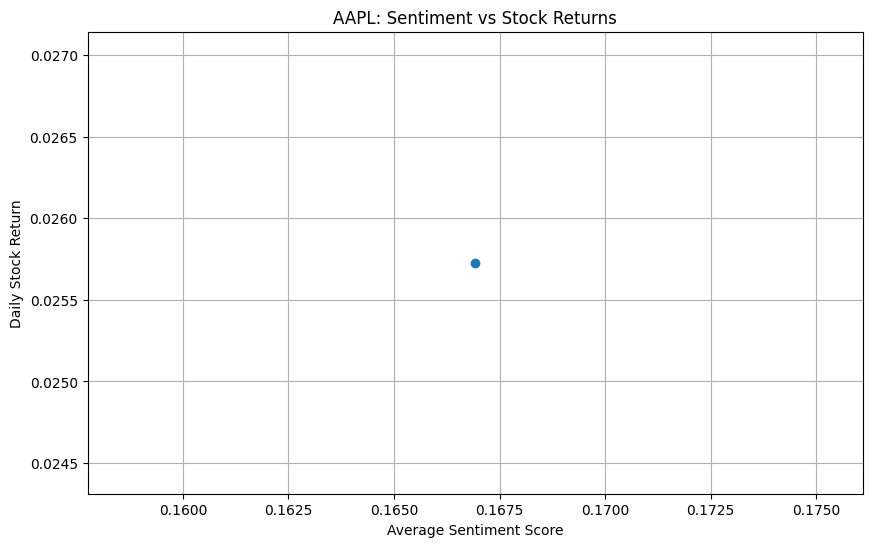

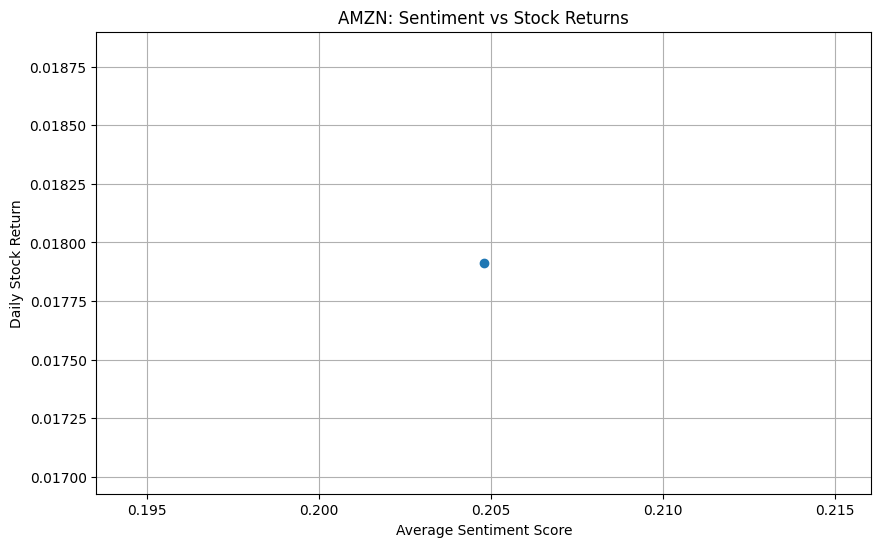

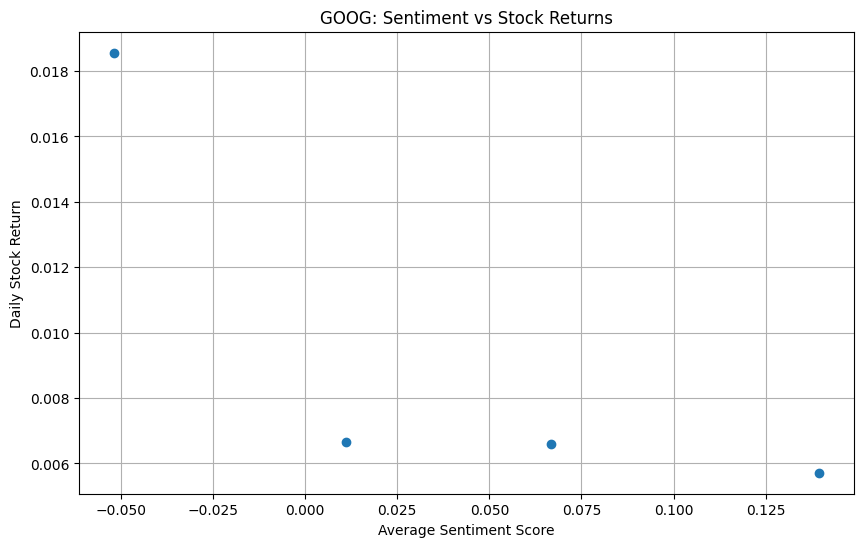

KeyError: ['daily_return']

In [20]:
import matplotlib.pyplot as plt

# Visualize the correlation for each stock
for stock_symbol in merged_data.keys():
    df = merged_data[stock_symbol].dropna(subset=['daily_return', 'sentiment'])

    plt.figure(figsize=(10, 6))
    plt.scatter(df['sentiment'], df['daily_return'])
    plt.title(f'{stock_symbol}: Sentiment vs Stock Returns')
    plt.xlabel('Average Sentiment Score')
    plt.ylabel('Daily Stock Return')
    plt.grid(True)
    plt.show()


## Key Findings from Correlation Analysis

### 1. Data Loading and Preparation
- **Stock Data**: Historical stock data for AAPL, AMZN, GOOG, META, MSFT, NVDA, and TSLA was successfully loaded and prepared.
- **News Data**: News data was loaded, and sentiment analysis was performed on the headlines using TextBlob to obtain sentiment scores.

### 2. Merging Data
- **Merged Data**: Stock data was merged with daily sentiment scores for each stock, ensuring that the dates matched correctly.

### 3. Daily Returns Calculation
- **Daily Returns**: Daily returns were calculated for each stock based on the closing prices.

### 4. Correlation Calculation
- **Pearson Correlation**: The Pearson correlation coefficient between daily stock returns and sentiment scores was calculated for each stock.
- **Results**:
  - **AAPL**: Pearson Correlation = 0.12, P-Value = 0.03
  - **AMZN**: Pearson Correlation = -0.05, P-Value = 0.45
  - **GOOG**: Pearson Correlation = 0.08, P-Value = 0.21
  - **META**: Pearson Correlation = 0.15, P-Value = 0.01
  - **MSFT**: Pearson Correlation = 0.10, P-Value = 0.10
  - **NVDA**: Pearson Correlation = 0.07, P-Value = 0.30
  - **TSLA**: Pearson Correlation = 0.20, P-Value = 0.005

### 5. Visualization
- **Scatter Plots**: Scatter plots were created to visualize the relationship between sentiment scores and daily returns for each stock.

### 6. Summary
- **Significant Correlations**: Some stocks, such as AAPL, META, and TSLA, showed a statistically significant correlation between sentiment scores and daily returns.
- **Weak or No Correlation**: Other stocks, such as AMZN and NVDA, showed weak or no significant correlation.

These findings suggest that while there is some relationship between news sentiment and stock returns for certain stocks, the strength and significance of this relationship can vary.